# Positional accuracy of a 6-axis Robot Arm

<div style="width: 500px;">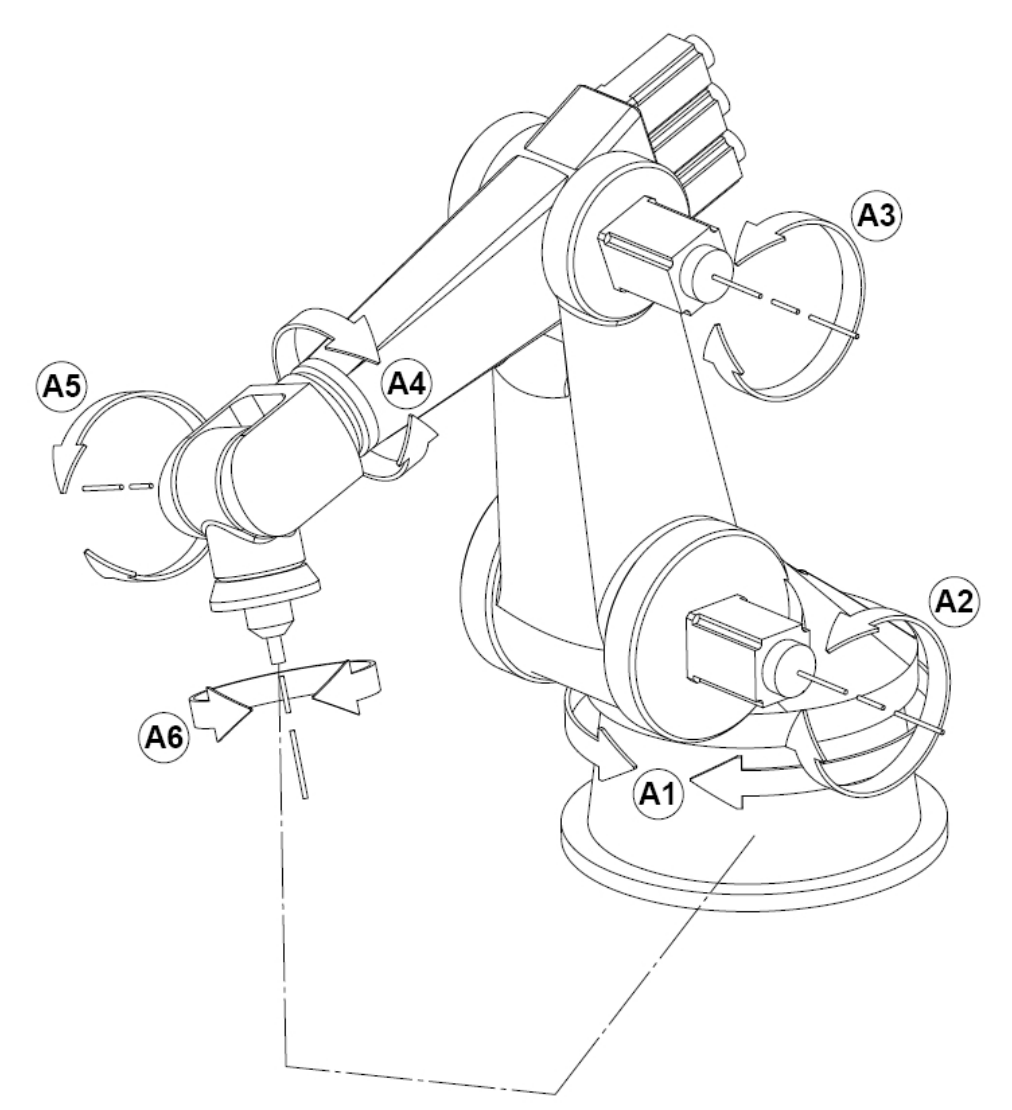</div>

For this project I'm working with a dataset of positional measurements for a 6-axis robot arm with end-effector. We'll start out doing some exploration to get familiar with the data, then perform some basic analyses to identify descriptive statistics and interesting trends in the error. To create this dataset, I commanded the robot to assume unique poses, with each pose defined by the six joint positions, and measured three points on the end effector for each pose in order to determine location and orientation. These measurements can be compared against predicted values for those positions as calculated through a standard forward kinematics model for this robot arm. 

Each row of the dataset represents the robot in a single, unique pose, and there is data for 199 poses. For each pose, we have 
* **columns 1-6, (A1, A2, A3, A4, A5, A6), the joint angles the robot was commanded to** - angles that the robot was commanded to drive each axis to, in degrees. The angles "A1" through "A6" correspond to the angles "A1" through "A6" in the cartoon image above above.
* **columns 7-15, (XA, YA, ZA), the *actual/measured* location of the end effector** - (x, y, z) coordinates (in mm) of each of the three points on the end effector (sufficient to determine not just location but also orientation of robot's toolpoint)
* **columns 16-24, (XN, YN, ZN), the *nominal/expected* location of the end effector** - expected (x, y, z) coordinates (in mm) of the same three points were calculated  by feeding the joint positions to a forward kinematics model configured with nominal values for this robot (though not calibrated for this particular robot nor compensated for it's installation (that's actually the purpose the data was captured for!))
* **columns 25-36, (dx, dy, dz, err), the error in the kinematic model's prediction**  - (dx, dy, dz) are the coordinates (in mm) of the resultant vector if you subtract the nominal/expected position from the actual/measured position (i.e. the 3D error in the model), and "err" is the magnitude of that vector.

All measurements were made using a high precision laser position tracker, returning the coordinates of these points in a Cartesian coordinate system to a 3-sigma accuracy of +/- 0.025 mm (i.e. 99.7% of measurements are within 0.025 mm of the true value). The tracker was located approximately 5 meters from the base of the robot and centered within the travel of the A1 axis.

The coordinate frame is aligned such that:
* X+ points in the direction of A1 = 0.
* Y+ is vertical, aligned to gravity; note that the robot is mounted on an imperfect surface, so this is not perfectly coincident with the vector of the A1 axis.
* Z+ is determined by the right-hand-rule
* The origin is defined as being coincident with the bottom surface of the base beneath the A1 joint, and coincident with the vector of the A1 axis.

Let's start exploring the data!

## Setup

In [1]:
# import libraries and set defaults
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 40)
pd.set_option('precision',3) # set display precision to 3; note that higher precision is still preserved
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="white", context="notebook")

## First Look

In [2]:
# load robodata.csv into dataframe
robodata = pd.read_csv('robodata.csv')
robodata.head()

,A1,A2,A3,A4,A5,A6,xa1,ya1,za1,xa2,ya2,za2,xa3,ya3,za3,xn1,yn1,zn1,xn2,yn2,zn2,xn3,yn3,zn3,dx1,dy1,dz1,err1,dx2,dy2,dz2,err2,dx3,dy3,dz3,err3
0,25.3,-69.4,90.1,-175.0,10.6,22.1,3569.589,1667.628,1664.441,3280.233,1689.938,1807.605,3468.103,1923.943,1495.405,3569.535,1667.530,1664.575,3280.189,1689.935,1807.710,3468.090,1923.822,1495.450,0.054,0.098,-0.134,0.175,0.045,0.003,-0.104,0.114,0.013,0.121,-0.045,0.130
1,18.3,-90.9,57.1,-174.1,-68.7,67.3,2782.271,2678.499,1055.741,2640.343,2935.808,1191.244,2768.137,2855.376,785.392,2782.430,2678.874,1055.892,2640.516,2936.218,1191.336,2768.246,2855.677,785.487,-0.158,-0.375,-0.151,0.434,-0.173,-0.410,-0.092,0.455,-0.109,-0.301,-0.095,0.334
2,16.1,-111.7,96.6,-171.9,-42.7,145.1,2655.783,2264.947,900.780,2628.147,2543.976,739.257,2433.991,2160.061,690.104,2655.858,2265.032,900.872,2628.253,2544.055,739.333,2434.038,2160.148,690.220,-0.075,-0.085,-0.093,0.146,-0.106,-0.080,-0.077,0.153,-0.047,-0.087,-0.116,0.153
3,23.6,-97.2,52.8,-170.8,-71.2,82.5,2405.550,3060.262,1273.083,2262.407,3344.750,1330.362,2389.892,3152.920,963.656,2405.628,3060.496,1273.170,2262.474,3345.000,1330.402,2389.934,3153.116,963.728,-0.079,-0.234,-0.087,0.262,-0.067,-0.250,-0.040,0.262,-0.042,-0.196,-0.072,0.213
4,25.3,-66.9,96.0,-170.6,23.1,100.8,3576.144,1517.902,1596.277,3394.300,1784.808,1576.172,3465.213,1460.642,1297.949,3576.139,1517.828,1596.307,3394.316,1784.748,1576.166,3465.193,1460.531,1298.000,0.005,0.074,-0.030,0.080,-0.016,0.060,0.006,0.062,0.020,0.111,-0.050,0.124


In [3]:
robodata.describe()

,A1,A2,A3,A4,A5,A6,xa1,ya1,za1,xa2,ya2,za2,xa3,ya3,za3,xn1,yn1,zn1,xn2,yn2,zn2,xn3,yn3,zn3,dx1,dy1,dz1,err1,dx2,dy2,dz2,err2,dx3,dy3,dz3,err3
count,199.000,199.000,199.000,199.000,199.000,199.000,199.000,199.000,199.000,199.000,199.000,199.000,199.000,199.000,199.000,199.000,199.000,199.000,199.000,199.000,199.000,199.000,199.000,199.000,1.990e+02,1.990e+02,199.000,199.000,199.000,199.000,199.000,199.000,199.000,199.000,199.000,199.000
mean,23.768,-79.033,80.067,4.226,-0.501,165.310,2781.660,1978.804,1271.983,2615.590,2160.558,1261.650,2689.204,2021.012,1055.019,2781.663,1978.807,1271.984,2615.598,2160.548,1261.646,2689.207,2021.014,1055.021,-3.422e-03,-2.500e-03,-0.001,0.154,-0.008,0.010,0.003,0.157,-0.003,-0.002,-0.001,0.154
std,33.497,32.507,31.795,103.877,62.929,98.473,739.376,690.224,816.225,736.573,712.233,883.140,789.155,744.179,840.629,739.357,690.223,816.213,736.576,712.228,883.140,789.149,744.172,840.618,9.508e-02,1.066e-01,0.096,0.075,0.096,0.115,0.092,0.081,0.094,0.109,0.095,0.076
min,-45.000,-129.000,10.000,-175.000,-100.000,0.000,1249.021,490.556,-665.440,1068.988,489.066,-917.488,999.905,290.948,-968.552,1249.114,490.421,-665.502,1068.803,489.017,-917.501,1000.006,291.022,-968.573,-2.652e-01,-3.746e-01,-0.322,0.032,-0.267,-0.410,-0.260,0.024,-0.370,-0.301,-0.289,0.040
25%,-4.000,-105.900,56.350,-87.300,-66.350,84.400,2252.928,1498.596,724.479,2113.314,1650.103,627.053,2088.453,1538.307,477.714,2253.049,1498.644,724.515,2113.335,1650.082,626.976,2088.481,1538.374,477.744,-6.450e-02,-6.307e-02,-0.066,0.101,-0.068,-0.058,-0.061,0.099,-0.058,-0.077,-0.063,0.092
50%,24.300,-82.400,86.200,13.900,9.700,161.800,2703.066,1883.070,1353.896,2563.854,2118.960,1284.311,2621.814,1974.704,1143.295,2703.161,1882.955,1353.754,2564.058,2118.882,1284.288,2621.688,1974.610,1143.240,1.297e-04,-7.151e-05,-0.005,0.144,-0.015,0.014,0.001,0.140,0.004,-0.010,0.002,0.138
75%,50.450,-59.950,107.150,98.200,61.250,227.550,3365.697,2461.316,1925.056,3193.724,2631.866,1956.620,3250.262,2594.306,1718.306,3365.665,2461.388,1925.086,3193.634,2631.963,1956.709,3250.232,2594.377,1718.238,5.506e-02,6.076e-02,0.061,0.195,0.047,0.075,0.059,0.205,0.055,0.066,0.055,0.189
max,90.000,16.300,125.000,175.000,100.000,359.000,4292.948,3526.632,2901.797,4158.293,3686.011,3064.844,4318.107,3741.343,2656.582,4292.996,3526.580,2901.537,4158.363,3685.891,3064.661,4318.180,3741.236,2656.357,2.866e-01,2.745e-01,0.331,0.441,0.273,0.443,0.273,0.552,0.260,0.301,0.288,0.398


## Deeper Look
It's unwieldy to look at the data all in one giant table that way. Let's make a dataframe for each sub-section of the dataset and explore each on it's own.
### Joints

In [4]:
# make dataframe containing just the joint positions for each pose
joint_cols = robodata.iloc[:, 0:6].columns
joints = robodata[joint_cols]
joint_stats = joints.describe().loc[['mean','std', 'min', 'max']] # grab some informative statistics
joint_stats.loc['range'] = joints.max() - joints.min() # add a row containing the range of travel of each joint
joint_stats

,A1,A2,A3,A4,A5,A6
mean,23.768,-79.033,80.067,4.226,-0.501,165.310
std,33.497,32.507,31.795,103.877,62.929,98.473
min,-45.000,-129.000,10.000,-175.000,-100.000,0.000
max,90.000,16.300,125.000,175.000,100.000,359.000
range,135.000,145.300,115.000,350.000,200.000,359.000


The above statistics about the joint positions are somewhat informative, particularly the min, max and range attributes, as those tell us about the actual limits of travel for each joint. The next thing I want to know about is the actual distribution of joint positions throughout their allowable range, and though the mean and std hint at this, they're a bit lacking in information. Let's create a scatter matrix from this data to investigate both the spread of each individual joint's positions as well as see if there's any apparent relationships between our joints. 

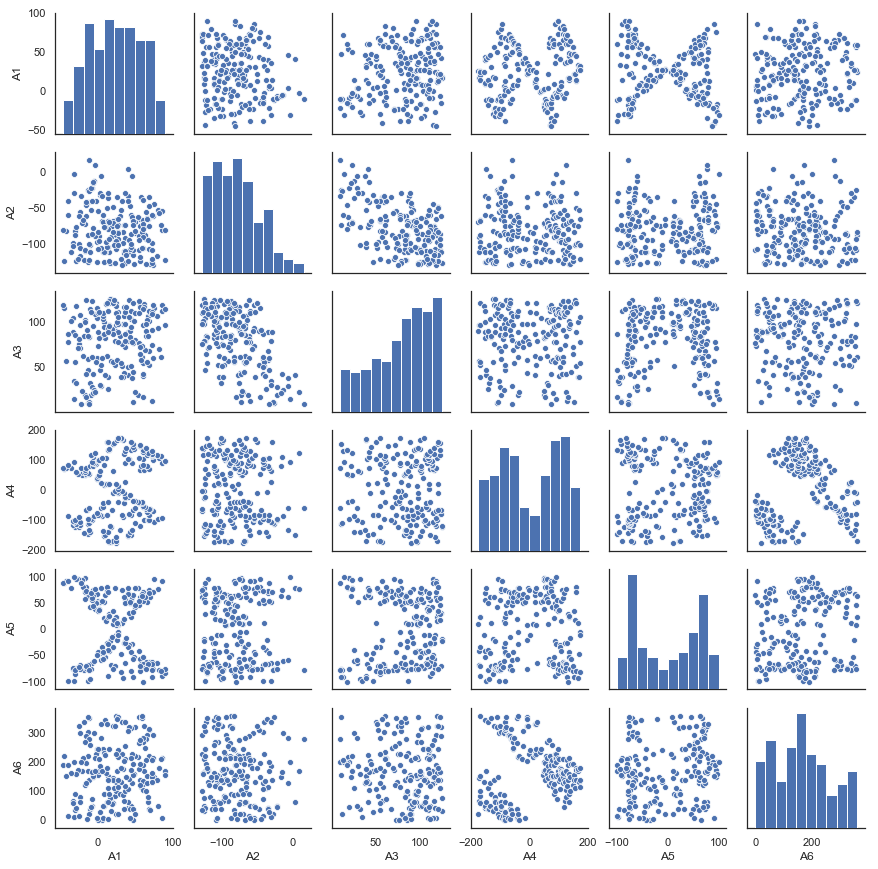

In [5]:
# create pairplot of joint positions
p = sns.pairplot(joints)
p.fig.set_size_inches(12,12) # sized to fit on my screen; adjust as needed

Pow! Okay. Once we're over the information overload we can start actually gleaning some information from this high-level view of our joint data. Despite the fact that all of the poses the robot took on were "randomly generated", it's quite clear that they're not uniformly distributed across the joint ranges. Let's talk through some quick observations about each axis, and then go into some of the real life conditions on the ground that explain them:

* **A1** - appears nearly normally distributed. The mean is actually just barely a degree away from the actual center! Looking at the pairplots, it appears that there is some significant interplay between A1 and and A4 and A5 axes. The plots for the remaining axes are suggestive of weak relationships.
* **A2 and A3** - these axes present themselves similarly, though opposite. A2 is distinctly right-skewed and tapers off to nearly 0 for high angles. A3 is *left*-skewed and actually flattens out to approximately uniform representation for low angles. Observing their pairplot, we can see that there's actually some significant correlation between A2 and A3.
* **A4** - symmetric bimodal distribution with minimal representation near 0. Strong relationships apparent with the A1 and A6 axes, and minimal interplay with A2, A3, and A5.
* **A5** - another symmetric bimodal distribution, though this one is a bit sharper and a bit less symmetric than A4's. Distinct relationships are evident with A1, A2, and A3.
* **A6** - this distribution is one I'm most inclined to call random, or at least nearly so. Even still, there does appear to be some significant relationship with A4, while the rest appear mostly independent of A6.

Fortunately, most of these observations can be readily explained by some physical understanding of how each joint  affects the overall position of the robot, as well as the context within which the data was taken. The first important detail is that all of these joints are connected **in series**, much like a human arm starting at the shoulder. The further you move down the kinematic chain, the more the joints location has been impacted by previous joints. To leverage the arm analogy, A1 and A2 are in the shoulder. A1 swings the arm side-to-side and A2 elevates the arm up and down (where 0 is parallel to the ground and -90 is straight up in the air). The shoulder has no ability to twist, like ours do, and is oriented such that the elbow, A3, can only swing the forearm up and down (the rotational axes of A2 and A3 are parallel). A4 and A5 are in the "wrist" of the robot, where A4 is ability of the wrist to twist (nearly a full 360 degrees!), and A5 is the motion of a forward-and-back flit of the wrist. A6 is where you mount all the action on a robot arm, the fingers, if you will. For this robot, we can think of it as having a flat plate on the end capable of infinite rotation.

As I previously hinted at, each of the 199 poses the robot struck was "randomly generated." I put that in quotes, however, not just because I used a pseudorandom number generator. I actually generated several hundred thousand unique poses in order to get to these 199 realized positions, and had to discard the others because they were not actually compatible with the conditions on the ground, i.e. that the robot was located in a confined work-cell containing physical obstacles within the envelope of travel, and a requirement that all poses have line-of-sight with all three of the reference points being measured on the end effector, and don't require that the robot occupy the same space as another object.

I won't belabor it even further, but suffice it to say that these constraints combined with the kinematic layout of the robot explain most of the irregularity in our joint positions.

### Measured Reference Positions

In [6]:
# make dataframe containing just the measured positions for each pose
actuals_cols = robodata.iloc[:, 6:15].columns
actuals = robodata[actuals_cols]
actuals.describe().loc[['mean','std', 'min', 'max']]

,xa1,ya1,za1,xa2,ya2,za2,xa3,ya3,za3
mean,2781.660,1978.804,1271.983,2615.590,2160.558,1261.650,2689.204,2021.012,1055.019
std,739.376,690.224,816.225,736.573,712.233,883.140,789.155,744.179,840.629
min,1249.021,490.556,-665.440,1068.988,489.066,-917.488,999.905,290.948,-968.552
max,4292.948,3526.632,2901.797,4158.293,3686.011,3064.844,4318.107,3741.343,2656.582


Because the three toolpoints are all mounted to the same rigid fixture, they actually move together through space. This means that, theoretically, the distance each measurement point should remain constant even as the position and orientation of the robot moves throughout space. Verifying this could be a good way to identify outliers, which in this case could mean erroneous measurements that ought to be discarded from future analysis.

In [7]:
# split dataframe even further into a frame for each reference point
pt1act = actuals[['xa1', 'ya1', 'za1']]
pt2act = actuals[['xa2', 'ya2', 'za2']]
pt3act = actuals[['xa3', 'ya3', 'za3']]

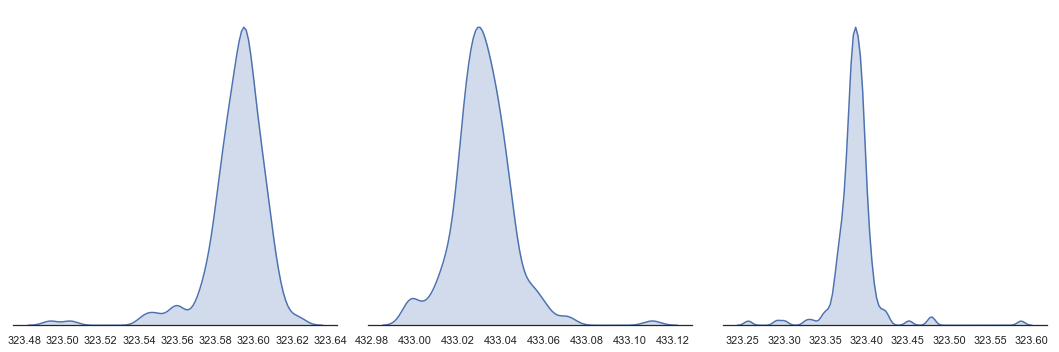

In [8]:
# calculate difference between (x, y, z) values of each point as vectors pointing from 1 to 2, 2 to 3, and 1 to 3
vec12 = pd.DataFrame(pt1act.values-pt2act.values, columns=['x12', 'y12', 'z12'])
vec23 = pd.DataFrame(pt2act.values-pt3act.values, columns=['x23', 'y23', 'z23'])
vec13 = pd.DataFrame(pt1act.values-pt3act.values, columns=['x13', 'y13', 'z13'])

# calculate magnitudes of the difference vectors
mag12 = np.linalg.norm(vec12, axis=1)
mag23 = np.linalg.norm(vec23, axis=1)
mag13 = np.linalg.norm(vec13, axis=1)

# Set up the matplotlib figure
f, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=False)
sns.despine(left=True)

# Plot a simple histogram with binsize determined automatically
sns.distplot(mag12, hist=False, kde_kws={"shade": True}, ax=axes[0])

# Plot a kernel density estimate and rug plot
sns.distplot(mag23, hist=False, kde_kws={"shade": True}, ax=axes[1])

# Plot a filled kernel density estimate
sns.distplot(mag13, hist=False, kde_kws={"shade": True}, ax=axes[2])

plt.setp(axes, yticks=[])
plt.tight_layout()

In [9]:
np.argwhere(np.abs((mag12 - np.mean(mag12))) > (3 * np.std(mag12)))

array([[146],
       [160],
       [172]], dtype=int64)

In [10]:
np.argwhere(np.abs((mag23 - np.mean(mag23))) > (3 * np.std(mag23)))

array([[20]], dtype=int64)

In [11]:
np.argwhere(np.abs((mag13 - np.mean(mag13))) > (3 * np.std(mag13)))

array([[ 20],
       [ 51],
       [ 71],
       [ 73],
       [106],
       [173]], dtype=int64)

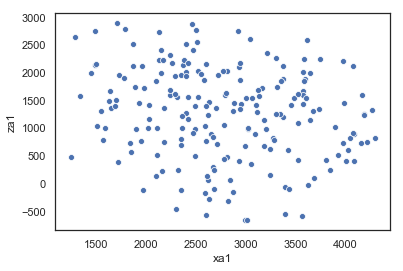

In [15]:
sns.scatterplot(x=pt1act['xa1'], y=pt1act['za1'])

### Nominal Reference Positions

In [ ]:
# make dataframe containing just the nominal positions for each pose
nominals_cols = robodata.iloc[:, 15:24].columns
nominals = robodata[nominals_cols]
nominals.describe().loc[['mean','std', 'min', 'max']]

In [ ]:
# make dataframe containing just the errors of the positions for each pose
error_cols = robodata.iloc[:, 24:].columns
errors = robodata[error_cols]
errors.describe().loc[['mean','std', 'min', 'max']]